In [1]:
import pandas as pd
import os
from trader_factory import build_active_IBridgePy_plus, build_trader_for_backtest
from IBridgePy.IbridgepyTools import symbol
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
t = build_trader_for_backtest()  # t is the IBridgePy_plus object

User do not specify an accountCode. IBridgePy uses dummyAccountCode
Backtester ignores order.tif=DAY and handles them as order.tif=GTC. We are working on this feature.
Config.config_defs::validate: IBridgePy has reset the TRADER.runMode to RUN_LIKE_QUANTOPIAN for backtesting! Otherwise, backtester will not generate BalanceLog.
Config.config_defs::validate: IBridgePy has reset projectConfig.repBarFreq to 60 for backtesting!


In [3]:
# Retrieve historical data of SPY, daily bar, and go back 8000 days.
hist = t.request_historical_data(symbol('SPY'), '1 day', '8000 D', dataProviderName='YahooFinance')

# In case, yahoo finance is down
# hist = pd.read_csv(os.path.join('Input', 'SPY.csv'), header=0, index_col=0)
hist.columns = map(str.lower, hist.columns)

In [4]:
hist.tail()

,open,high,low,close,volume,dividends,stock splits
Date,,,,,,,
2021-10-04,433.000000,433.959991,426.359985,428.640015,128570000,0.0,0
2021-10-05,430.239990,435.489990,429.390015,433.100006,90682500,0.0,0
2021-10-06,429.269989,435.119995,427.540009,434.899994,113032200,0.0,0
2021-10-07,438.390015,441.679993,438.200012,438.660004,72437500,0.0,0
2021-10-08,439.480011,439.890015,437.190002,437.859985,74492900,0.0,0


In [5]:
def add_yield(hist):
    hist['close_yesterday'] = hist['close'].shift(1)  # add a new column, call it "close_yesterday"
    hist['close_price_change_from_yesterday_to_today'] = (hist['close'] - hist['close_yesterday']) / hist['close_yesterday']
    hist['close_price_change_from_today_to_tomorrow'] = hist['close_price_change_from_yesterday_to_today'].shift(-1)
    return hist

hist = add_yield(hist)

In [6]:
hist.dropna(inplace=True)  # sklearn cannot handle NA and has to drop them. Two rows are droppes as a result.

In [7]:
hist.tail()

,open,high,low,close,volume,dividends,stock splits,close_yesterday,close_price_change_from_yesterday_to_today,close_price_change_from_today_to_tomorrow
Date,,,,,,,,,,
2021-10-01,430.980011,436.029999,427.230011,434.239990,129240100,0.0,0,429.140015,0.011884,-0.012896
2021-10-04,433.000000,433.959991,426.359985,428.640015,128570000,0.0,0,434.239990,-0.012896,0.010405
2021-10-05,430.239990,435.489990,429.390015,433.100006,90682500,0.0,0,428.640015,0.010405,0.004156
2021-10-06,429.269989,435.119995,427.540009,434.899994,113032200,0.0,0,433.100006,0.004156,0.008646
2021-10-07,438.390015,441.679993,438.200012,438.660004,72437500,0.0,0,434.899994,0.008646,-0.001824


In [8]:
# Use machine learning package and build a linear regression model to predit tomorrow's price.
x = hist[['close_price_change_from_yesterday_to_today']]
y = hist['close_price_change_from_today_to_tomorrow']
model = LinearRegression()
model.fit(x, y)
print(model.coef_)
print(model.intercept_)

[-0.09674857]
0.0003902639518274893


In [9]:
# Create a column of predicted prices using the linear regression model
preds = model.predict(hist.loc[:, ["close_price_change_from_yesterday_to_today"]])

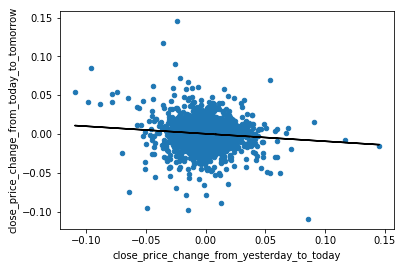

In [10]:
# Draw a scatter plot.
# The black line is drawn to visualize the trend
hist.plot.scatter(x = "close_price_change_from_yesterday_to_today", y = "close_price_change_from_today_to_tomorrow")
plt.plot(hist['close_price_change_from_yesterday_to_today'], preds, color="black")

In [11]:
# Summarize everything into a function to calculate linear regression coef
# Then, build a stock screener

def machine_learning(hist):
    hist['close_yesterday'] = hist['close'].shift(1)  # add a new column, call it "close_yesterday"
    hist['close_price_change_from_yesterday_to_today'] = (hist['close'] - hist['close_yesterday']) / hist['close_yesterday']
    hist['close_price_change_from_today_to_tomorrow'] = hist['close_price_change_from_yesterday_to_today'].shift(-1)
    hist.dropna(inplace=True)
    x = hist[['close_price_change_from_yesterday_to_today']]
    y = hist['close_price_change_from_today_to_tomorrow']
    model = LinearRegression()
    model.fit(x, y)
    return model.coef_

In [12]:
# Build a stock screener to check which stocks have a strong autocorrelation
ans = {}
for ticker in ['SPY', 'QQQ', 'AAPL', 'GOOG', 'TSLA']:  # You can add more tickers to try
    hist = t.request_historical_data(symbol(ticker), '1 day', '8000 D', dataProviderName='YahooFinance')
    coef = machine_learning(hist)
    ans[ticker] = coef[0]
ans
#{'SPY': -0.09470177988805199,
# 'QQQ': -0.06317144933170069,
# 'AAPL': -0.04901759160663959,
# 'GOOG': -0.021715123012021144,
# 'TSLA': 0.0026507635409099566}

{'SPY': -0.0967484721490346,
 'QQQ': -0.06430020489974961,
 'AAPL': -0.04363057810532057,
 'GOOG': -0.0210733992328272,
 'TSLA': 0.0023575055026069046}

array([0.00623341])

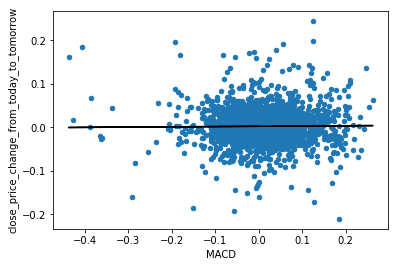

In [13]:
def machine_learning_on_MACD(hist, drawPlot=False):
    # Add indicators of moving average and MACD
    hist['MA_10'] = hist['close'].rolling(window=10, center=False, min_periods=1).mean()
    hist['MA_30'] = hist['close'].rolling(window=30, center=False, min_periods=1).mean()
    hist['MACD'] = (hist['MA_10'] - hist['MA_30']) / hist['close']
    
    # Build liner regression model
    hist = add_yield(hist)
    hist.dropna(inplace=True)
    x = hist[['MACD']]
    y = hist['close_price_change_from_today_to_tomorrow']
    model = LinearRegression()
    model.fit(x, y)
    
    if drawPlot:
        # Draw plot to visualize
        preds = model.predict(hist.loc[:, ["MACD"]])
        hist.plot.scatter(x = "MACD", y = "close_price_change_from_today_to_tomorrow")
        plt.plot(hist['MACD'], preds, color="black")
    return model.coef_

machine_learning_on_MACD(hist, drawPlot=True)

In [14]:
# Build a stock screener
ans = {}
for ticker in ['SPY', 'QQQ', 'AAPL', 'GOOG', 'TSLA']:
    hist = t.request_historical_data(symbol(ticker), '1 day', '8000 D', dataProviderName='YahooFinance')
    coef = machine_learning_on_MACD(hist)
    ans[ticker] = coef[0]
ans
#{'SPY': -0.013643619115926403,
# 'QQQ': -0.001030927719538247,
# 'AAPL': 0.003731356518772369,
# 'GOOG': 0.003867687194693938,
# 'TSLA': 0.00657561500065246}

{'SPY': -0.01372438004030318,
 'QQQ': -0.002696186120634684,
 'AAPL': 0.0039960456990051916,
 'GOOG': 0.003700758590714109,
 'TSLA': 0.006299489978185032}